# End-to-End Demonstration

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/reddragon/efficient-dl-survey-paper/blob/main/demo.ipynb)

This colab demonstrates various efficiency techniques as described in the [Efficient Deep Learning paper](https://arxiv.org/abs/2106.08962) on the CIFAR-10 dataset and a CNN-based model family.

## Creating the Dataset

In [1]:
# Dataset tensorflow_datasets kütüphanesi aracılığı ile indirilmektedir. Bilgisayarınızın home klasörüne otomatik olarak indirilmektedir. Bkz: 16. satır
# BU BLOK ÇALIŞTIRILDIKTAN SONRA KERNEL RESTART EDİLMELİDİR.
# Kodlar Ubuntu 24.04'te Python 3.17.16 sürümü ile başarıyla çalıştırılmıştır. Bkz: Çıktıların çalıştırma zamanı
# Epoch sayısı 100'den 3'e hızlı çalıştırılması amacıyla düşürülmüştür. 

# Makalenin ve Kodların Orijinal Linkleri:
# https://dl.acm.org/doi/10.1145/3578938
# https://arxiv.org/pdf/2106.08962
# https://github.com/reddragon/efficient-dl-survey-paper/blob/main/demo.ipynb


# %pip install --upgrade pip
# %pip install np_utils
# %pip install keras==2.0.4
%pip install tensorflow==2.5
# %pip install tensorflow-datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras import utils

import tensorflow_datasets as tfds
def load_data():
  """Loads CIFAR10 dataset."""
  cifar10_data = tfds.load("cifar10")
  x_train = np.zeros([50000, 32, 32, 3], dtype=np.uint8)
  y_train = np.zeros([50000, 1], dtype=np.uint8)
  i = 0
  for example in tfds.as_numpy(cifar10_data['train']):
    x_train[i] = example['image']
    y_train[i] = example['label']
    i = i + 1

  x_test = np.zeros([10000, 32, 32, 3])
  y_test = np.zeros([10000, 1])
  i = 0
  for example in tfds.as_numpy(cifar10_data['test']):
    x_test[i] = example['image']
    y_test[i] = example['label']
    i = i + 1

  return (x_train, y_train), (x_test, y_test)

def normalize_x(x):
  x = x.astype('float32')
  x /= 127.5
  x -= 1.0
  # TODO: Remove
  # mean = np.mean(x,axis=(0,1,2,3))
  # std = np.std(x,axis=(0,1,2,3))
  # x = (x-mean)/(std+1e-7)
  # x = np.reshape(x, [-1, 32*32*3])
  return x

def normalize_y(y, num_classes):
  if y.shape[1] == 1:
    y = utils.to_categorical(y, num_classes)
  return y

def get_data(dataset, num_classes=10):
  (train_x, train_y), (test_x, test_y) = load_data()
  return normalize_x(train_x), normalize_y(train_y, num_classes), normalize_x(test_x), normalize_y(test_y, num_classes)

cifar10_train_x, cifar10_train_y, cifar10_test_x, cifar10_test_y = get_data(10)

2024-05-17 21:02:47.985435: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-05-17 21:02:49.746430: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-17 21:02:51.379525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:02:51.379768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 245.91GiB/s
2024-05-17 21:02:51.379815: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-05-17 21:02:51.520399: I tensorflow/stream_executor/pl

## Defining the Model

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers


def base_model(
    num_classes=10,        # Number of classes in the model. 
    width_multiplier=1.0,  # Factor for scaling the network size.
    params={},             # Additional hyper-params.
):
  # Use the width_multiplier for scaling the network, the larger the value,
  # the larger the network. Keep a bound on the width though.
  w = min(max(width_multiplier, 0.05), 3.0)

  inputs = keras.Input(shape=(32, 32, 3))
  x = inputs

  # Add a data augmentation module, that can be turned on/off with
  # hyper-params.
  if params.get('data_augmentation', True):
    if params.get('easier_data_augmentation', False):
      data_augmentation_module = keras.Sequential([
          layers.experimental.preprocessing.RandomFlip('horizontal'),
          # layers.experimental.preprocessing.RandomTranslation(3. / 32, 3. / 32),
          # TODO: Remove this, only valid for wm=1.4
          # layers.experimental.preprocessing.RandomTranslation(3. / 32, 3. / 32),
          # layers.experimental.preprocessing.RandomContrast(0.2),
          # layers.experimental.preprocessing.RandomFlip('vertical'),
      ])
    else:
      data_augmentation_module = keras.Sequential([
          layers.experimental.preprocessing.RandomFlip('horizontal'),
          # layers.experimental.preprocessing.RandomTranslation(3. / 32, 3. / 32),
          # TODO: Remove this, only valid for wm=1.4
          layers.experimental.preprocessing.RandomTranslation(3. / 32, 3. / 32),
          # layers.experimental.preprocessing.RandomContrast(0.2),
          # layers.experimental.preprocessing.RandomFlip('vertical'),
      ])

    x = data_augmentation_module(inputs)

  # Create a regularizer to be used.
  reg = keras.regularizers.l2(params.get('l2_reg_weight', 2e-4))

  # Find the dropout rate for helping with further regularization.
  dropout_rate = params.get('dropout_rate', 1.0)

  # We will keep the first 'block' of layers scale invariant.

  x = layers.Conv2D(
      32, (3, 3), padding='same', activation='relu', kernel_regularizer=reg)(
          x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(
      32, (3, 3), padding='same', activation='relu', kernel_regularizer=reg)(
          x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  # x = layers.Dropout(dropout_rate)(x)

  # A short hand for the round method.
  r = lambda v: round(v)

  # We will start to scale layers from here on.
  x = layers.Conv2D(
      # Note that the number of filters grows / shrinks with `w`.
      r(64 * w), 
      (3, 3), 
      padding='same',
      activation='relu',
      kernel_regularizer=reg)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(
      r(64 * w), 
      (3, 3),
      padding='same',
      activation='relu',
      kernel_regularizer=reg)(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  # x = layers.Dropout(dropout_rate)(x)

  x = layers.Conv2D(
      r(128 * w), 
      (3, 3),
      padding='same',
      activation='relu',
      kernel_regularizer=reg)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(
      r(128 * w), 
      (3, 3),
      padding='same',
      activation='relu',
      kernel_regularizer=reg)(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  # x = layers.Dropout(dropout_rate)(x)

  x = layers.Flatten()(x)
  # TODO: Check if we need extra Dense layers in between.
  # x = Dense(512, activation='relu', kernel_regularizer=reg)(x)
  # x = Dropout(0.5)(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Dense(r(512 * w), activation='relu', kernel_regularizer=reg)(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Dense(num_classes, kernel_regularizer=reg)(x)
  logits = x
  probabilities = layers.Activation('softmax')(logits)

  # In case we only want the logits, return just that.
  outputs = logits if params.get('only_logits', False) else probabilities
  return keras.Model(inputs=inputs, outputs=outputs)


base_model()

## Helper Methods for Model Training

In [4]:
def get_compiled_model(num_classes=10,
                       width_multiplier=1.0,
                       loss_fn='categorical_crossentropy',
                       metric_fn='categorical_accuracy',
                       params={},
                       hp=None):
  if hp:
    learning_rate = hp.Choice('learning_rate', values=[5e-3, 1e-3, 5e-4, 1e-4])
    # decay_rate = hp.Float(
    #     'decay_rate', min_value=0.5, max_value=1.0, sampling='linear')

    params['dropout_rate'] = hp.Choice(
        'dropout_rate', values=[0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15])
    params['l2_reg_weight'] = hp.Choice(
        'l2_reg_weight', values=[1e-3, 2e-4, 1e-5, 1e-6, 0.0])
  else:
    learning_rate = params.get('learning_rate', 1e-3)
    # decay_rate = params.get('decay_rate', 1.0)

  model = base_model(
      num_classes, width_multiplier=width_multiplier, params=params)

  # lr = keras.optimizers.schedules.ExponentialDecay(
  #       initial_learning_rate=initial_lr, decay_steps=10000,
  #       decay_rate=decay_rate)

  opt = keras.optimizers.Adam(learning_rate=learning_rate)
  # opt = keras.optimizers.Adam()
  model.compile(loss=loss_fn, optimizer=opt, metrics=metric_fn)
  return model

In [5]:
import os

# Create a directory for the checkpoints.
!mkdir -p checkpoints

# Now let us create a callback for saving the best checkpoint so far.
# It tries to find the checkpoint with the maximum categorical accuracy.
# We will provide this to the model.fit function.

CHECKPOINTS_DIR='checkpoints'

def best_checkpoint_callback(model_name):
  checkpoint_dir_path = os.path.join(CHECKPOINTS_DIR, model_name)
  if not os.path.exists(checkpoint_dir_path):
    os.mkdir(checkpoint_dir_path)
  checkpoint_path = os.path.join(checkpoint_dir_path, model_name)
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)


def load_best_checkpoint(model, model_name):
  checkpoint_dir_path = os.path.join(CHECKPOINTS_DIR, model_name)
  checkpoint_path = os.path.join(checkpoint_dir_path, model_name)
  model.load_weights(checkpoint_path)
  return model

In [6]:
import pickle

!mkdir -p histories

def persist_history(history_obj, model_name):
  history_path = os.path.join('histories', model_name)
  pickle.dump(history_obj, open(history_path, 'wb'))

def load_history(model_name):
  history_path = os.path.join('histories', model_name)
  return pickle.load(open(history_path, 'rb'))

# persist_history(model_wm_20_aug_history.history, 'model_wm_20_aug')
# history = load_history('model_wm_20_aug')

In [7]:
# TODO: Uncomment later.
# keras.utils.plot_model(model_wm_01)

### TFLite Export and Eval

In [8]:
def tflite_model_eval(model_content, test_images, test_labels, quantized):
  # Load the TFLite model and allocate tensors.
  interpreter = tf.lite.Interpreter(model_content=model_content)
  interpreter.allocate_tensors()

  # Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Test the model on random input data.
  input_shape = input_details[0]['shape']

  num_correct = 0
  num_total = 0
  # input_data = np.random.rand(1, 32, 32, 3).astype(np.int8)
  for idx in range(len(test_images)):
    num_total = num_total + 1

    input_data = test_images[idx:idx+1]
    if quantized:
      # Rescale that data to be in [-127, 127] and then convert to int8.
      input_data = (input_data * 127).astype(np.int8)

    # print(test_labels[0])
    # input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    # print(output_data)

    # print(test_labels[idx].shape, output_data[0].shape)
    if np.argmax(test_labels[idx]) == np.argmax(output_data[0]):
      num_correct = num_correct + 1
  
  print('Accuracy:', num_correct * 1.0 / num_total)

In [9]:
# Create the directory for storing TFLite models.
!mkdir -p 'tflite_models'

def convert_and_eval(keras_model, model_name, quantized_export, test_dataset_x, 
                     test_dataset_y):
  converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
  if quantized_export:

    converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE, 
                               tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
    def representative_dataset():
      for idx in range(min(len(test_dataset_x), 100)):
        yield [test_dataset_x[idx:idx+1]]

    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8  # or tf.uint8
    converter.inference_output_type = tf.int8  # or tf.uint8

  converter.use_experimental_new_converter = True
  tflite_model_str = converter.convert()
  model_name = '{}_{}.tflite'.format(
      model_name, ('quantized' if quantized_export else 'float'))
  print('Model Name: {}, Quantized: {}'.format(model_name, quantized_export))
  print('Model Size: {:.2f} KB'.format(len(tflite_model_str) / 1024.))
  with open(os.path.join('tflite_models', model_name), 'wb') as f:
    f.write(tflite_model_str)
  
  tflite_model_eval(tflite_model_str, test_dataset_x, test_dataset_y, 
                    quantized_export)

In [10]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

### Unified Method for Model Training

In [11]:
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_model(width_multiplier, params={}, batch_size=128, epochs=3):
  model_name = 'wm_{}_{}'.format(
      str(width_multiplier).replace('.', ''),
      ('aug' if params.get('data_augmentation', False) else 'no_aug')
  )

  model = get_compiled_model(
      width_multiplier=width_multiplier,
      params=params)

  model.summary()

  lr_reducer = ReduceLROnPlateau(
      factor=np.sqrt(0.1),
      cooldown=0,
      patience=5,
      min_lr=0.5e-6)

  data_gen = (width_multiplier > 1.0)
  # Now we can train the model.
  if data_gen:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        # horizontal_flip=True,  # randomly flip images
        # vertical_flip=False,  # randomly flip images
        preprocessing_function=get_random_eraser(p=0.5, v_l=-1.0, v_h=1.0, s_l = 0.1, pixel_level=False))

    # Fit the model on the batches generated by datagen.flow().
    model_history = model.fit_generator(datagen.flow(cifar10_train_x, cifar10_train_y, batch_size=batch_size),
                        steps_per_epoch=cifar10_train_x.shape[0] // batch_size,
                        validation_data=(cifar10_test_x, cifar10_test_y),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=[best_checkpoint_callback(model_name), lr_reducer],
                        # callbacks=[best_checkpoint_callback(model_name)],
                        )
  else:
    model_history = model.fit(
        cifar10_train_x, 
        cifar10_train_y, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(cifar10_test_x, cifar10_test_y),
        # callbacks=[best_checkpoint_callback(model_name), lr_reducer],
        callbacks=[best_checkpoint_callback(model_name)],
        shuffle=True)

  

  model = load_best_checkpoint(model, model_name)
  model.evaluate(cifar10_test_x, cifar10_test_y)

  convert_and_eval(model, model_name, False, cifar10_test_x, cifar10_test_y)
  convert_and_eval(model, model_name, True, cifar10_test_x, cifar10_test_y)

  persist_history(model_history.history, model_name)
  return model, model_history.history


## Training Models w/ & w/o Augmentation

### Width Multiplier = 0.05

In [12]:
width_multiplier = 0.05
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.0,
    'l2_reg_weight': 0.0,
    'data_augmentation': False,
}
_, wm_005_no_aug_history = train_model(width_multiplier, params)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 3)         867 

2024-05-17 21:03:00.984632: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-17 21:03:01.040266: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8902
2024-05-17 21:03:01.241268: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-17 21:03:01.241314: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2024-05-17 21:03:01.241587: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-17 21:03:01.241683: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-17 21:03:01.324145: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

391/391 [==============================] - 6s 10ms/step - loss: 1.6446 - categorical_accuracy: 0.3928 - val_loss: 1.5401 - val_categorical_accuracy: 0.4609
Epoch 2/3
391/391 [==============================] - 3s 9ms/step - loss: 1.3101 - categorical_accuracy: 0.5255 - val_loss: 1.3318 - val_categorical_accuracy: 0.5316
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 1.2126 - categorical_accuracy: 0.5712


2024-05-17 21:03:14.248551: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpndf7smwj/assets


INFO:tensorflow:Assets written to: /tmp/tmpndf7smwj/assets
2024-05-17 21:03:15.533760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:03:15.533883: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:03:15.533980: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:03:15.534371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:03:15.534459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_005_no_aug_float.tflite, Quantized: False
Model Size: 65.60 KB
Accuracy: 0.5712
INFO:tensorflow:Assets written to: /tmp/tmpp6eck_qd/assets


INFO:tensorflow:Assets written to: /tmp/tmpp6eck_qd/assets
2024-05-17 21:03:21.316116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:03:21.316235: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:03:21.316297: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:03:21.316609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:03:21.316748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_005_no_aug_quantized.tflite, Quantized: True
Model Size: 26.99 KB
Accuracy: 0.5731


In [13]:
width_multiplier = 0.05
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.0,
    'l2_reg_weight': 0.0,
    'data_augmentation': True,
    'easier_data_augmentation': True,
}
_, wm_005_aug_history = train_model(width_multiplier, params)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0   

INFO:tensorflow:Assets written to: /tmp/tmpv53072r0/assets
2024-05-17 21:07:06.503909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:07:06.504105: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:07:06.504169: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:07:06.504524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:07:06.504607: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_005_aug_float.tflite, Quantized: False
Model Size: 65.70 KB
Accuracy: 0.5407
INFO:tensorflow:Assets written to: /tmp/tmpctrxjye2/assets


INFO:tensorflow:Assets written to: /tmp/tmpctrxjye2/assets
2024-05-17 21:07:12.684264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:07:12.684378: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:07:12.684434: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:07:12.684688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:07:12.684769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_005_aug_quantized.tflite, Quantized: True
Model Size: 27.12 KB
Accuracy: 0.5463


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

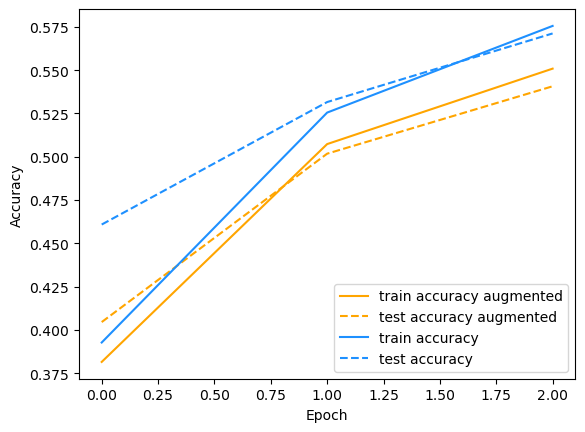

In [15]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_005_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_005_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_005_no_aug_history['categorical_accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(wm_005_no_aug_history['val_categorical_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 0.1

In [16]:
width_multiplier = 0.1
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': False,
}
_, wm_01_no_aug_history = train_model(width_multiplier, params)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 6)         1734

INFO:tensorflow:Assets written to: /tmp/tmpbbl602j9/assets
2024-05-17 21:10:52.953324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:10:52.953441: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:10:52.953524: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:10:52.953799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:10:52.953881: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_01_no_aug_float.tflite, Quantized: False
Model Size: 109.82 KB
Accuracy: 0.5956
INFO:tensorflow:Assets written to: /tmp/tmpak1y1jgd/assets


INFO:tensorflow:Assets written to: /tmp/tmpak1y1jgd/assets
2024-05-17 21:10:59.299901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:10:59.300009: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:10:59.300064: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:10:59.300356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:10:59.300438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_01_no_aug_quantized.tflite, Quantized: True
Model Size: 38.78 KB
Accuracy: 0.5995


In [17]:
width_multiplier = 0.1
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': True,
    'easier_data_augmentation': True,
}
_, wm_01_aug_history = train_model(width_multiplier, params)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_25 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0   

INFO:tensorflow:Assets written to: /tmp/tmpd29fjski/assets
2024-05-17 21:14:54.226320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:14:54.226452: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:14:54.226516: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:14:54.227258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:14:54.227343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_01_aug_float.tflite, Quantized: False
Model Size: 109.82 KB
Accuracy: 0.6183
INFO:tensorflow:Assets written to: /tmp/tmp566kz09b/assets


INFO:tensorflow:Assets written to: /tmp/tmp566kz09b/assets
2024-05-17 21:15:01.379494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:15:01.379615: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:15:01.379700: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:15:01.379989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:15:01.380079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_01_aug_quantized.tflite, Quantized: True
Model Size: 38.79 KB
Accuracy: 0.6167


In [18]:
print(wm_005_aug_history)


{'loss': [1.6636072397232056, 1.3536710739135742, 1.2425652742385864], 'categorical_accuracy': [0.3815999925136566, 0.5073400139808655, 0.5508800148963928], 'val_loss': [1.6579036712646484, 1.4049980640411377, 1.295575737953186], 'val_categorical_accuracy': [0.40459999442100525, 0.501800000667572, 0.5407000184059143]}


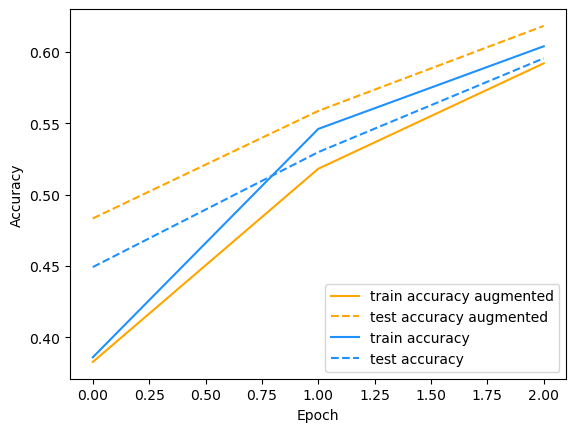

In [19]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_01_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_01_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_01_no_aug_history['categorical_accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(wm_01_no_aug_history['val_categorical_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 0.25

In [20]:
width_multiplier = 0.25
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': False,
}
_, wm_025_no_aug_history = train_model(width_multiplier, params)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_30 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_31 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 16)        4624

INFO:tensorflow:Assets written to: /tmp/tmp_hv9owdk/assets
2024-05-17 21:18:57.044580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:18:57.044695: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:18:57.044756: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:18:57.045075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:18:57.045157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_025_no_aug_float.tflite, Quantized: False
Model Size: 392.74 KB
Accuracy: 0.7057
INFO:tensorflow:Assets written to: /tmp/tmpbkpyvesx/assets


INFO:tensorflow:Assets written to: /tmp/tmpbkpyvesx/assets
2024-05-17 21:19:03.792077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:19:03.792248: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:19:03.792313: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:19:03.792670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:19:03.792759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_025_no_aug_quantized.tflite, Quantized: True
Model Size: 111.27 KB
Accuracy: 0.7057


In [21]:
width_multiplier = 0.25
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': True,
    # 'easier_data_augmentation': True,
}
_, wm_025_aug_history = train_model(width_multiplier, params)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0   

INFO:tensorflow:Assets written to: /tmp/tmpu1ke2h74/assets
2024-05-17 21:23:38.566387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:23:38.566498: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:23:38.566553: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:23:38.566860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:23:38.566946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_025_aug_float.tflite, Quantized: False
Model Size: 392.74 KB
Accuracy: 0.6525
INFO:tensorflow:Assets written to: /tmp/tmplzy2m0id/assets


INFO:tensorflow:Assets written to: /tmp/tmplzy2m0id/assets
2024-05-17 21:23:45.537560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:23:45.537676: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:23:45.537734: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:23:45.537987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:23:45.538076: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_025_aug_quantized.tflite, Quantized: True
Model Size: 111.27 KB
Accuracy: 0.6557


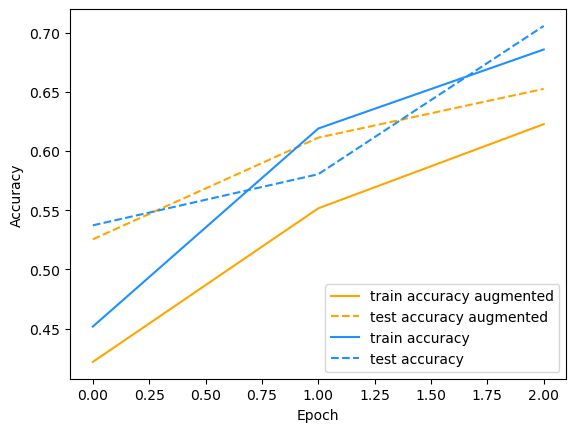

In [22]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_025_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_025_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_025_no_aug_history['categorical_accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(wm_025_no_aug_history['val_categorical_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 0.5

In [23]:
width_multiplier = 0.50
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': False,
}
_, wm_050_no_aug_history = train_model(width_multiplier, params)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_42 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_43 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 16, 16, 32)        9248

INFO:tensorflow:Assets written to: /tmp/tmp3rl7jtjt/assets
2024-05-17 21:28:13.093927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:28:13.094063: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:28:13.094127: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:28:13.094461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:28:13.094542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_05_no_aug_float.tflite, Quantized: False
Model Size: 1374.36 KB
Accuracy: 0.6912
INFO:tensorflow:Assets written to: /tmp/tmp9ih0k79j/assets


INFO:tensorflow:Assets written to: /tmp/tmp9ih0k79j/assets
2024-05-17 21:28:20.415422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:28:20.415535: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:28:20.415611: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:28:20.416084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:28:20.416171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_05_no_aug_quantized.tflite, Quantized: True
Model Size: 359.58 KB
Accuracy: 0.6964


In [24]:
width_multiplier = 0.50
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': True,
}
_, wm_050_aug_history = train_model(width_multiplier, params)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_48 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_49 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 32)        0   

INFO:tensorflow:Assets written to: /tmp/tmp2a8ll5zh/assets
2024-05-17 21:34:30.548812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:34:30.548928: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:34:30.548982: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:34:30.549372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:34:30.549452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_05_aug_float.tflite, Quantized: False
Model Size: 1374.36 KB
Accuracy: 0.7136
INFO:tensorflow:Assets written to: /tmp/tmp7mt0l2ea/assets


INFO:tensorflow:Assets written to: /tmp/tmp7mt0l2ea/assets
2024-05-17 21:34:38.940552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:34:38.940668: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:34:38.940760: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:34:38.940939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:34:38.941021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_05_aug_quantized.tflite, Quantized: True
Model Size: 359.58 KB
Accuracy: 0.7144


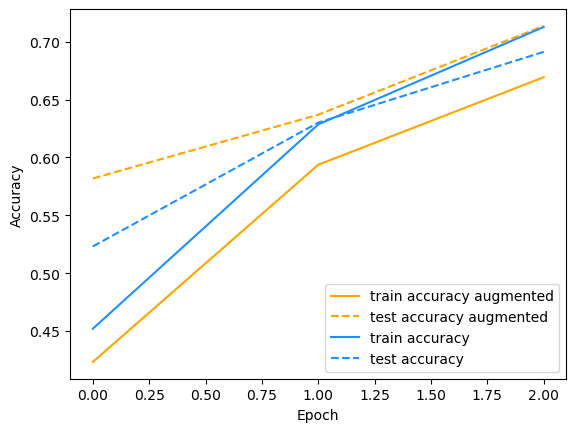

In [25]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_050_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_050_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_050_no_aug_history['categorical_accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(wm_050_no_aug_history['val_categorical_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 0.75

In [26]:
width_multiplier = 0.75
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': False,
}
_, wm_075_no_aug_history = train_model(width_multiplier, params)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_54 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_55 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 16, 16, 48)        1387

INFO:tensorflow:Assets written to: /tmp/tmp_neuqo13/assets
2024-05-17 21:40:47.433469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:40:47.433581: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:40:47.433659: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:40:47.433996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:40:47.434083: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_075_no_aug_float.tflite, Quantized: False
Model Size: 2993.94 KB
Accuracy: 0.7333
INFO:tensorflow:Assets written to: /tmp/tmp9qr3h5w4/assets


INFO:tensorflow:Assets written to: /tmp/tmp9qr3h5w4/assets
2024-05-17 21:40:56.087567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:40:56.087686: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:40:56.087744: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:40:56.088056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:40:56.088135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_075_no_aug_quantized.tflite, Quantized: True
Model Size: 767.35 KB
Accuracy: 0.7337


#### With Augmentation

In [27]:
width_multiplier = 0.75
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': True,
}
_, wm_075_aug_history = train_model(width_multiplier, params)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_60 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_61 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 32)        0  

INFO:tensorflow:Assets written to: /tmp/tmptlok3hw_/assets
2024-05-17 21:49:54.257437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:49:54.257546: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:49:54.257606: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:49:54.257786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:49:54.257867: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_075_aug_float.tflite, Quantized: False
Model Size: 2994.02 KB
Accuracy: 0.73
INFO:tensorflow:Assets written to: /tmp/tmp45tq05tz/assets


INFO:tensorflow:Assets written to: /tmp/tmp45tq05tz/assets
2024-05-17 21:50:04.398628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:50:04.398745: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:50:04.398826: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:50:04.399019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:50:04.399121: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_075_aug_quantized.tflite, Quantized: True
Model Size: 767.42 KB
Accuracy: 0.7298


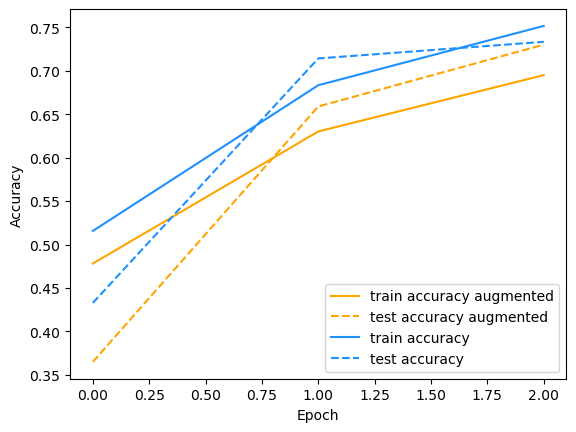

In [28]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_075_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_075_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_075_no_aug_history['categorical_accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(wm_075_no_aug_history['val_categorical_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 1.0

In [29]:
width_multiplier = 1.0
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': False,
}
_, wm_10_no_aug_history = train_model(width_multiplier, params)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_66 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_67 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 16, 16, 64)        184

INFO:tensorflow:Assets written to: /tmp/tmpw1cmb7_1/assets
2024-05-17 21:59:08.401831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:59:08.401946: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:59:08.402025: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:59:08.402389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:59:08.402473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_10_no_aug_float.tflite, Quantized: False
Model Size: 5251.64 KB
Accuracy: 0.7607
INFO:tensorflow:Assets written to: /tmp/tmp10oq01yp/assets


INFO:tensorflow:Assets written to: /tmp/tmp10oq01yp/assets
2024-05-17 21:59:19.474383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:59:19.474538: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-17 21:59:19.474594: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-17 21:59:19.474974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-17 21:59:19.475072: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_10_no_aug_quantized.tflite, Quantized: True
Model Size: 1334.73 KB


In [ ]:
width_multiplier = 1.0
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': True,
}
_, wm_10_aug_history = train_model(width_multiplier, params)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_72 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_73 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 16, 16, 32)        0  

INFO:tensorflow:Assets written to: /tmp/tmpiix3r81v/assets
2024-05-12 15:24:08.312836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 15:24:08.312966: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 15:24:08.313036: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 15:24:08.313420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 15:24:08.313510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_10_aug_float.tflite, Quantized: False
Model Size: 5251.64 KB
Accuracy: 0.7398
INFO:tensorflow:Assets written to: /tmp/tmpzv8rw20g/assets


INFO:tensorflow:Assets written to: /tmp/tmpzv8rw20g/assets
2024-05-12 15:24:19.340365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 15:24:19.340507: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 15:24:19.340616: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 15:24:19.340914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 15:24:19.340997: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_10_aug_quantized.tflite, Quantized: True
Model Size: 1334.73 KB
Accuracy: 0.7435


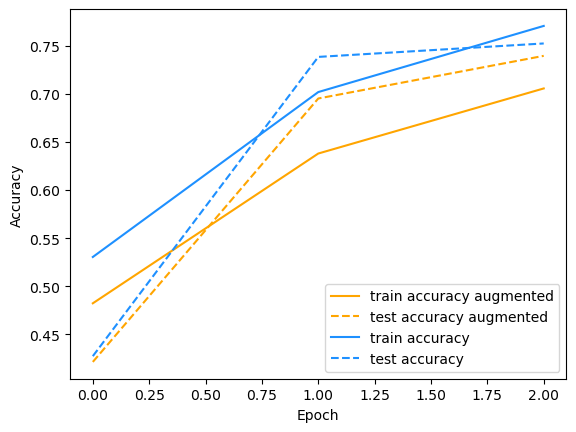

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_10_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_10_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_10_no_aug_history['categorical_accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(wm_10_no_aug_history['val_categorical_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 1.4

In [ ]:
width_multiplier = 1.4
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'dropout': 0.3,
    'data_augmentation': True,
}
wm_14_aug, wm_14_aug_history = train_model(width_multiplier, params, epochs=3)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_84 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_85 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 32)        0  

/home/x/anaconda3/envs/computerVision/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


390/390 [==============================] - 9s 21ms/step - loss: 1.6832 - categorical_accuracy: 0.4241 - val_loss: 2.0916 - val_categorical_accuracy: 0.3331
Epoch 2/3
390/390 [==============================] - 8s 20ms/step - loss: 1.1682 - categorical_accuracy: 0.5843 - val_loss: 1.0430 - val_categorical_accuracy: 0.6281
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - loss: 0.8785 - categorical_accuracy: 0.6976
INFO:tensorflow:Assets written to: /tmp/tmpwuictrzs/assets


INFO:tensorflow:Assets written to: /tmp/tmpwuictrzs/assets
2024-05-12 15:57:30.934524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 15:57:30.934661: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 15:57:30.934720: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 15:57:30.935042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 15:57:30.935123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_14_aug_float.tflite, Quantized: False
Model Size: 10186.52 KB
Accuracy: 0.6976
INFO:tensorflow:Assets written to: /tmp/tmpxfdhj_bw/assets


INFO:tensorflow:Assets written to: /tmp/tmpxfdhj_bw/assets
2024-05-12 15:57:53.046035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 15:57:53.046147: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 15:57:53.046205: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 15:57:53.046489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 15:57:53.046634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_14_aug_quantized.tflite, Quantized: True
Model Size: 2573.14 KB
Accuracy: 0.6969


In [ ]:
width_multiplier = 1.4
params = {
    'learning_rate': 5e-4,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-4,
    'data_augmentation': False,
}
_, wm_14_no_aug_history = train_model(width_multiplier, params, epochs=3)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_90 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_91 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 16, 16, 90)        260

/home/x/anaconda3/envs/computerVision/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


390/390 [==============================] - 9s 20ms/step - loss: 1.7258 - categorical_accuracy: 0.4631 - val_loss: 2.1631 - val_categorical_accuracy: 0.3470
Epoch 2/3
390/390 [==============================] - 8s 19ms/step - loss: 1.2124 - categorical_accuracy: 0.6292 - val_loss: 1.0225 - val_categorical_accuracy: 0.6983
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - loss: 0.9362 - categorical_accuracy: 0.7293
INFO:tensorflow:Assets written to: /tmp/tmp83nuh7bk/assets


INFO:tensorflow:Assets written to: /tmp/tmp83nuh7bk/assets
2024-05-12 16:46:25.178996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 16:46:25.179137: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 16:46:25.179198: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 16:46:25.179420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 16:46:25.179510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_14_no_aug_float.tflite, Quantized: False
Model Size: 10186.52 KB
Accuracy: 0.7293
INFO:tensorflow:Assets written to: /tmp/tmp8oa61j0s/assets


INFO:tensorflow:Assets written to: /tmp/tmp8oa61j0s/assets
2024-05-12 16:46:49.991779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 16:46:49.991899: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 16:46:49.991959: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 16:46:49.992241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 16:46:49.992325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_14_no_aug_quantized.tflite, Quantized: True
Model Size: 2573.14 KB
Accuracy: 0.7253


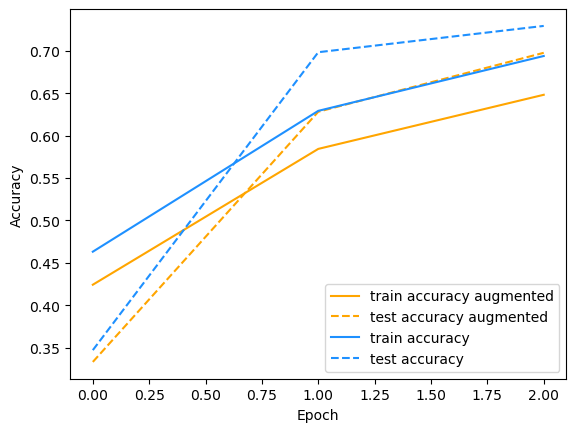

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_14_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_14_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_14_no_aug_history['categorical_accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(wm_14_no_aug_history['val_categorical_accuracy'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

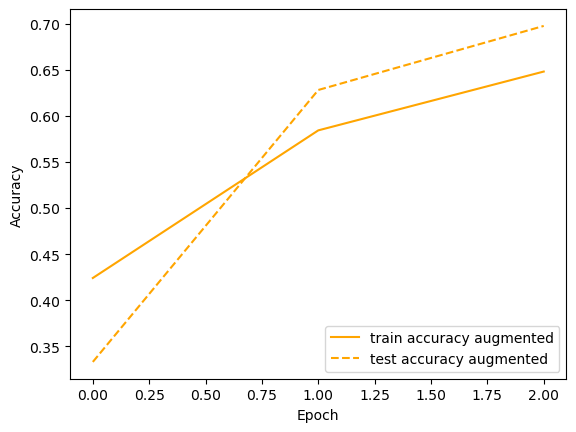

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_14_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_14_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

# plt.plot(wm_14_no_aug_history['categorical_accuracy'],
#          label='train accuracy',
#          c='dodgerblue', ls='-')
# plt.plot(wm_14_no_aug_history['val_categorical_accuracy'],
#          label='test accuracy',
#          c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

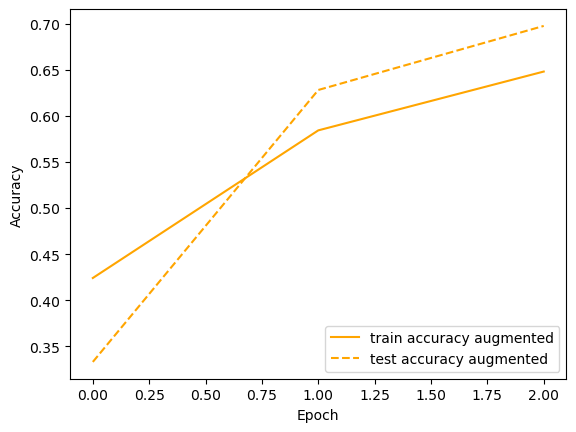

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_14_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_14_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

# plt.plot(wm_14_no_aug_history['categorical_accuracy'],
#          label='train accuracy',
#          c='dodgerblue', ls='-')
# plt.plot(wm_14_no_aug_history['val_categorical_accuracy'],
#          label='test accuracy',
#          c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

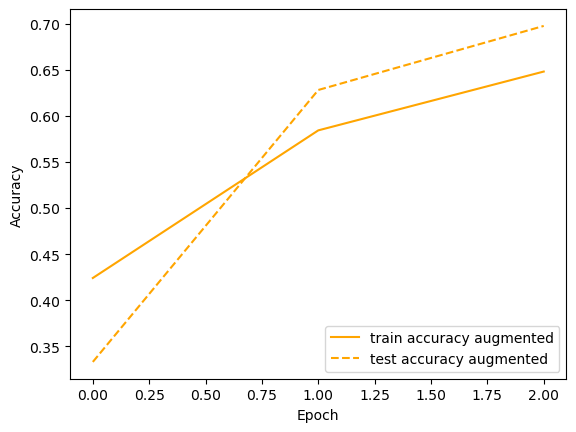

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_14_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_14_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

# plt.plot(wm_14_no_aug_history['categorical_accuracy'],
#          label='train accuracy',
#          c='dodgerblue', ls='-')
# plt.plot(wm_14_no_aug_history['val_categorical_accuracy'],
#          label='test accuracy',
#          c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Training Models w/ Distillation

In [ ]:
def prepare_teacher_model(teacher_model, test_dataset_x, test_dataset_y):
  teacher_model_with_logits = keras.Model(teacher_model.inputs, 
                                          teacher_model.layers[-2].output)
  teacher_model_with_logits.summary()
  teacher_model_with_logits.compile(metrics=keras.metrics.CategoricalAccuracy())
  teacher_model_with_logits.evaluate(test_dataset_x, test_dataset_y)

  for layer in teacher_model_with_logits.layers:
    layer.Trainable = False
  
  return teacher_model_with_logits

teacher_model_with_logits = prepare_teacher_model(wm_14_aug, cifar10_test_x, 
                                                  cifar10_test_y)

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_84 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_85 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 32)        0  

In [ ]:
class Distiller(keras.Model):
  def __init__(self, student, teacher):
      super(Distiller, self).__init__()
      self.teacher = teacher
      self.student = student

  def compile(
      self,
      optimizer,
      metrics,
      student_loss_fn,
      distillation_loss_fn,
      alpha=0.1,
      temperature=3,
  ):
    super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
    self.student_loss_fn = student_loss_fn
    self.distillation_loss_fn = distillation_loss_fn
    self.alpha = alpha
    self.temperature = temperature

  def call(self, inputs, training=None, mask=None):
    return self.student(inputs, training=training)

  def train_step(self, data):
    # Unpack data
    x, y = data

    # Forward pass of teacher
    teacher_predictions = self.teacher(x, training=False)

    with tf.GradientTape() as tape:
      # Forward pass of student
      student_predictions = self.student(x, training=True)

      # Compute losses
      student_loss = self.student_loss_fn(y, student_predictions)
      # distillation_loss = 0.0
      distillation_loss = self.distillation_loss_fn(
          tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
          tf.nn.softmax(student_predictions / self.temperature, axis=1),
      )
      loss = student_loss + self.alpha * distillation_loss

    # Compute gradients
    trainable_vars = self.student.trainable_variables
    # gradients = tape.gradient(loss, trainable_vars)

    # Update weights
    # self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.optimizer.minimize(loss, trainable_vars, tape=tape)

    # Update the metrics configured in `compile()`.
    self.compiled_metrics.update_state(y, student_predictions)

    # Return a dict of performance
    results = {m.name: m.result() for m in self.metrics}
    results.update({
        "student_loss": student_loss, 
        # "distillation_loss": distillation_loss
    })
    return results

  def test_step(self, data):
    # Unpack the data
    x, y = data

    # Compute predictions
    y_prediction = self.student(x, training=False)

    # Calculate the loss
    student_loss = self.student_loss_fn(y, y_prediction)

    # Update the metrics.
    self.compiled_metrics.update_state(y, y_prediction)

    # Return a dict of performance
    results = {m.name: m.result() for m in self.metrics}
    results.update({'student_loss': student_loss})
    return results

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy

def get_compiled_distilled_model(
    teacher_model_with_logits,
    num_classes=10,
    width_multiplier=1.0,
    student_loss_fn=CategoricalCrossentropy(from_logits=True),
    # student_loss_fn=CategoricalCrossentropy(),
    distillation_loss_fn=CategoricalCrossentropy(from_logits=True),
    metric_fn='categorical_accuracy',
    params={},
    hp=None):
  if hp:
    pass
  else:
    learning_rate = params.get('learning_rate', 1e-3)
    alpha = params.get('alpha', 0.3)
    temperature = params.get('temperature', 1.0)
  
  # Make the model not append a softmax activation layer at the end.
  params['only_logits'] = True
  student_model = base_model(
      num_classes, width_multiplier=width_multiplier, params=params)

  compiled_distilled_model = Distiller(student=student_model, 
                        teacher=teacher_model_with_logits)
  compiled_distilled_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=metric_fn,
      student_loss_fn=student_loss_fn,
      distillation_loss_fn=distillation_loss_fn,
      alpha=alpha,
      temperature=temperature,
  )

  # Build and compile the student model so that it can be evaluated and exported.
  student_model.build(teacher_model_with_logits.input_shape)
  student_model.compile(loss=student_loss_fn, metrics=metric_fn)
  return compiled_distilled_model, student_model

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

def train_model_with_distillation(
    width_multiplier, 
    teacher_model_with_logits=None,
    params={}, 
    batch_size=128, 
    epochs=3):
  model_name = 'wm_{}_{}{}'.format(
      str(width_multiplier).replace('.', ''),
      ('aug' if params.get('data_augmentation', False) else 'no_aug'),
      ('_dist' if teacher_model_with_logits else ''),
  )

  if teacher_model_with_logits:
    # We are doing distillation.
    model_to_train, model_to_deploy = get_compiled_distilled_model(
      teacher_model_with_logits, 
      width_multiplier=width_multiplier,
      params=params)
    
    lr_reducer = ReduceLROnPlateau(
        # monitor='val_student_loss',
        monitor='val_categorical_accuracy',
        factor=np.sqrt(0.1),
        cooldown=0,
        patience=5,
        min_lr=0.5e-6)
  else:
    # Training the model solo.
    model_to_train = get_compiled_model(
        width_multiplier=width_multiplier,
        params=params)
    model_to_deploy = model_to_train

    lr_reducer = ReduceLROnPlateau(
        factor=np.sqrt(0.1),
        cooldown=0,
        patience=5,
        min_lr=0.5e-6)

  model_to_deploy.summary()

  # Now we can train the model.
  model_to_train_history = model_to_train.fit(
      cifar10_train_x, 
      cifar10_train_y, 
      batch_size=batch_size, 
      epochs=epochs, 
      validation_data=(cifar10_test_x, cifar10_test_y),
      callbacks=[best_checkpoint_callback(model_name), lr_reducer],
      # callbacks=[best_checkpoint_callback(model_name)],
      shuffle=True)

  model_to_train = load_best_checkpoint(model_to_train, model_name)
  model_to_deploy.evaluate(cifar10_test_x, cifar10_test_y)

  convert_and_eval(model_to_deploy, model_name, False, cifar10_test_x, 
                   cifar10_test_y)
  convert_and_eval(model_to_deploy, model_name, True, cifar10_test_x, 
                   cifar10_test_y)

  persist_history(model_to_train_history.history, model_name)
  return model_to_train, model_to_train_history.history

### Width Multiplier = 0.05

In [ ]:
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.0,
    'l2_reg_weight': 0.0,
    'alpha': 2.0,
    'data_augmentation': True,
    'easier_data_augmentation': True,
}
_, wm_005_aug_dist_history = train_model_with_distillation(
    width_multiplier=0.05, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params, epochs=3)

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_96 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_97 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 16, 16, 32)        0  

INFO:tensorflow:Assets written to: /tmp/tmpls0jvst8/assets
2024-05-12 17:07:09.577474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:07:09.577597: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 17:07:09.577667: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 17:07:09.577968: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:07:09.578048: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_005_aug_dist_float.tflite, Quantized: False
Model Size: 65.64 KB
Accuracy: 0.551
INFO:tensorflow:Assets written to: /tmp/tmpaypwgg02/assets


INFO:tensorflow:Assets written to: /tmp/tmpaypwgg02/assets
2024-05-12 17:07:15.375136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:07:15.375254: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 17:07:15.375312: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 17:07:15.375667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:07:15.375748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_005_aug_dist_quantized.tflite, Quantized: True
Model Size: 27.02 KB
Accuracy: 0.5511


In [ ]:
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.0,
    'l2_reg_weight': 0.0,
    'alpha': 1.0,
    'data_augmentation': False,
}
_, wm_005_no_aug_dist_history = train_model_with_distillation(
    width_multiplier=0.05, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params)

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_102 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_103 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 16, 16, 3)         867

INFO:tensorflow:Assets written to: /tmp/tmpps5gii56/assets
2024-05-12 17:10:58.868445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:10:58.868654: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 17:10:58.868753: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 17:10:58.869275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:10:58.869378: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_005_no_aug_dist_float.tflite, Quantized: False
Model Size: 65.67 KB
Accuracy: 0.5576
INFO:tensorflow:Assets written to: /tmp/tmp496y1fqe/assets


INFO:tensorflow:Assets written to: /tmp/tmp496y1fqe/assets
2024-05-12 17:11:04.706846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:11:04.706963: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 17:11:04.707019: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 17:11:04.707379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:11:04.707470: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_005_no_aug_dist_quantized.tflite, Quantized: True
Model Size: 27.05 KB
Accuracy: 0.5554


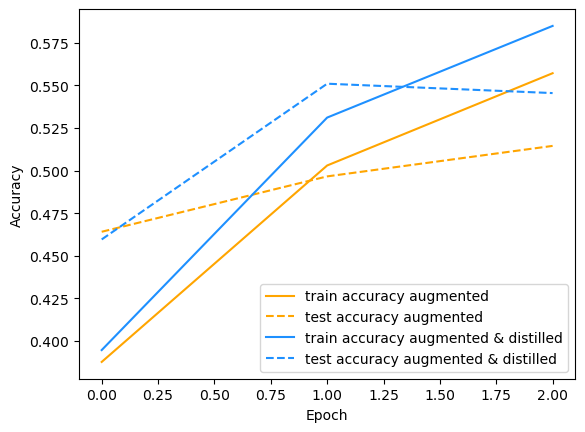

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_005_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_005_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_005_aug_dist_history['categorical_accuracy'],
         label='train accuracy augmented & distilled',
         c='dodgerblue', ls='-')
plt.plot(wm_005_aug_dist_history['val_categorical_accuracy'],
         label='test accuracy augmented & distilled',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 0.1

In [ ]:
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'alpha': 1.0,
    'data_augmentation': False,
}
_, wm_01_no_aug_dist_history = train_model_with_distillation(
    width_multiplier=0.1, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params)

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_108 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_109 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 16, 16, 6)         173

INFO:tensorflow:Assets written to: /tmp/tmpujkeldnc/assets
2024-05-12 17:14:44.432382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:14:44.432500: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 17:14:44.432565: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 17:14:44.432887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:14:44.432966: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_01_no_aug_dist_float.tflite, Quantized: False
Model Size: 109.78 KB
Accuracy: 0.6381
INFO:tensorflow:Assets written to: /tmp/tmpxmpg663j/assets


INFO:tensorflow:Assets written to: /tmp/tmpxmpg663j/assets
2024-05-12 17:14:50.697199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:14:50.697317: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 17:14:50.697379: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 17:14:50.697704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:14:50.697784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_01_no_aug_dist_quantized.tflite, Quantized: True
Model Size: 38.69 KB
Accuracy: 0.6349


In [ ]:
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'alpha': 0.5,
    'data_augmentation': True,
    'easier_data_augmentation': True,
}
_, wm_01_aug_dist_history = train_model_with_distillation(
    width_multiplier=0.1, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params, epochs=100)

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_10 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_114 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_115 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 16, 16, 32)        0  

INFO:tensorflow:Assets written to: /tmp/tmpt8s6swq1/assets
2024-05-12 17:26:55.286551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:26:55.286687: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 17:26:55.286773: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 17:26:55.287068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:26:55.287164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_01_aug_dist_float.tflite, Quantized: False
Model Size: 109.78 KB
Accuracy: 0.7952
INFO:tensorflow:Assets written to: /tmp/tmpl2sqe_au/assets


INFO:tensorflow:Assets written to: /tmp/tmpl2sqe_au/assets
2024-05-12 17:27:01.536128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:27:01.536247: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 17:27:01.536310: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 17:27:01.536546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:27:01.536683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_01_aug_dist_quantized.tflite, Quantized: True
Model Size: 38.69 KB
Accuracy: 0.7904


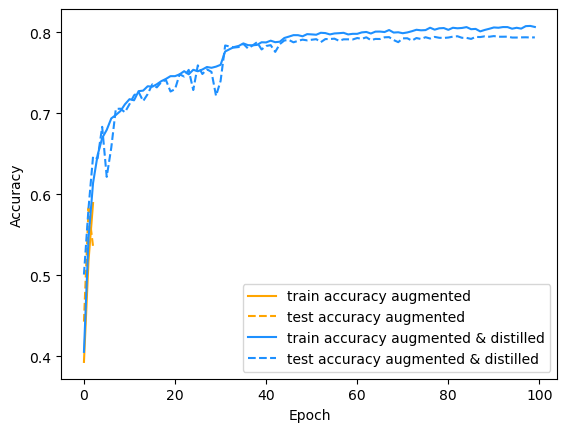

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_01_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_01_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_01_aug_dist_history['categorical_accuracy'],
         label='train accuracy augmented & distilled',
         c='dodgerblue', ls='-')
plt.plot(wm_01_aug_dist_history['val_categorical_accuracy'],
         label='test accuracy augmented & distilled',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

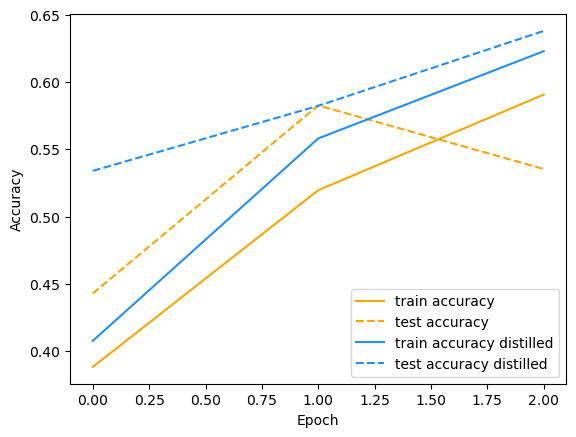

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_01_no_aug_history['categorical_accuracy'],
         label='train accuracy',
         c='orange', ls='-')
plt.plot(wm_01_aug_history['val_categorical_accuracy'],
         label='test accuracy',
         c='orange',ls='--')

plt.plot(wm_01_no_aug_dist_history['categorical_accuracy'],
         label='train accuracy distilled',
         c='dodgerblue', ls='-')
plt.plot(wm_01_no_aug_dist_history['val_categorical_accuracy'],
         label='test accuracy distilled',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 0.25

In [ ]:
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.0,
    'l2_reg_weight': 0.0,
    'alpha': 1.0,
    'data_augmentation': True,
}
_, wm_025_aug_dist_history = train_model_with_distillation(
    width_multiplier=0.25, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params)

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_11 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_120 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_121 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 16, 16, 32)        0  

INFO:tensorflow:Assets written to: /tmp/tmpzxndyr5j/assets
2024-05-12 17:31:02.531400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:31:02.531515: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 17:31:02.531619: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 17:31:02.531979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:31:02.532058: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_025_aug_dist_float.tflite, Quantized: False
Model Size: 392.68 KB
Accuracy: 0.6794
INFO:tensorflow:Assets written to: /tmp/tmpabfijy19/assets


INFO:tensorflow:Assets written to: /tmp/tmpabfijy19/assets
2024-05-12 17:31:08.509000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:31:08.509114: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 17:31:08.509170: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 17:31:08.509474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:31:08.509554: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_025_aug_dist_quantized.tflite, Quantized: True
Model Size: 111.16 KB
Accuracy: 0.6795


3


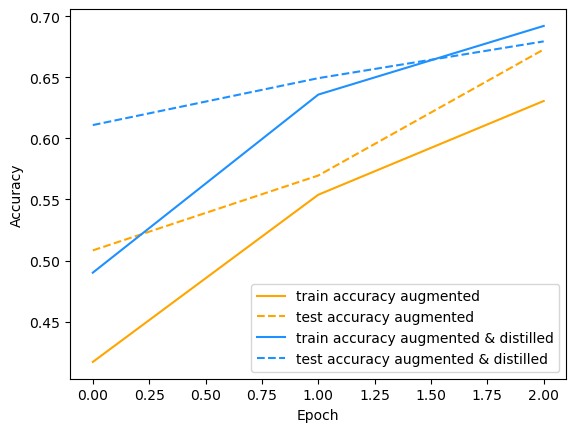

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_025_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_025_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

print(len(wm_025_aug_dist_history['categorical_accuracy']))

plt.plot(wm_025_aug_dist_history['categorical_accuracy'],
         label='train accuracy augmented & distilled',
         c='dodgerblue', ls='-')
plt.plot(wm_025_aug_dist_history['val_categorical_accuracy'],
         label='test accuracy augmented & distilled',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 0.5

In [ ]:
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'alpha': 1.0,
    'data_augmentation': True,
}
_, wm_050_aug_dist_history = train_model_with_distillation(
    width_multiplier=0.5, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params)

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_12 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_126 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_127 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 16, 16, 32)        0  

INFO:tensorflow:Assets written to: /tmp/tmpxqnqcgik/assets
2024-05-12 17:35:35.774055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:35:35.774178: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 17:35:35.774289: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 17:35:35.774588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:35:35.774693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_05_aug_dist_float.tflite, Quantized: False
Model Size: 1374.31 KB
Accuracy: 0.6966
INFO:tensorflow:Assets written to: /tmp/tmp1r041zt9/assets


INFO:tensorflow:Assets written to: /tmp/tmp1r041zt9/assets
2024-05-12 17:35:43.161847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:35:43.162000: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 17:35:43.162096: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 17:35:43.162414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:35:43.162536: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_05_aug_dist_quantized.tflite, Quantized: True
Model Size: 359.48 KB
Accuracy: 0.6969


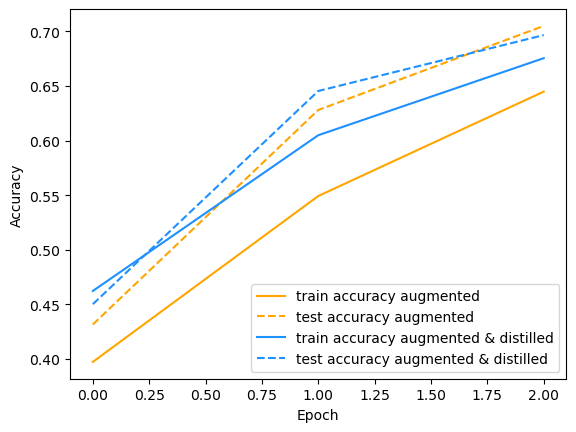

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_050_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_050_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_050_aug_dist_history['categorical_accuracy'],
         label='train accuracy augmented & distilled',
         c='dodgerblue', ls='-')
plt.plot(wm_050_aug_dist_history['val_categorical_accuracy'],
         label='test accuracy augmented & distilled',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 0.75

In [ ]:
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'data_augmentation': True,
    'alpha': 1.0,
    'temperature': 1.0
}
_, wm_075_aug_dist_history = train_model_with_distillation(
    width_multiplier=0.75, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params,
    epochs=3)

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_14 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_138 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_139 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 16, 16, 32)        0  

INFO:tensorflow:Assets written to: /tmp/tmpdxzrcley/assets
2024-05-12 17:57:45.309568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:57:45.309744: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 17:57:45.309811: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 17:57:45.310124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:57:45.310211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_075_aug_dist_float.tflite, Quantized: False
Model Size: 2993.88 KB
Accuracy: 0.722
INFO:tensorflow:Assets written to: /tmp/tmpp3qkvllo/assets


INFO:tensorflow:Assets written to: /tmp/tmpp3qkvllo/assets
2024-05-12 17:57:58.181323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:57:58.181474: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 17:57:58.181646: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 17:57:58.182043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 17:57:58.182186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_075_aug_dist_quantized.tflite, Quantized: True
Model Size: 767.24 KB
Accuracy: 0.7249


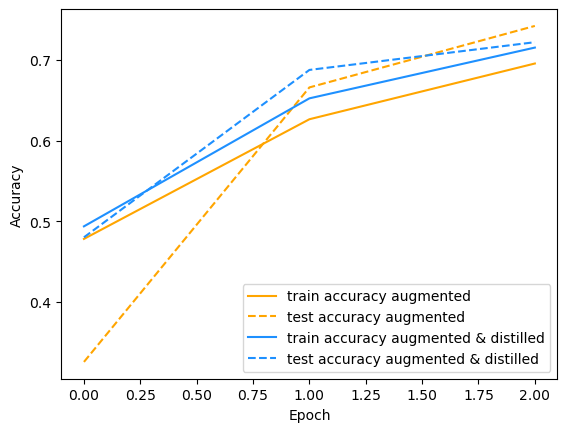

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_075_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_075_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_075_aug_dist_history['categorical_accuracy'],
         label='train accuracy augmented & distilled',
         c='dodgerblue', ls='-')
plt.plot(wm_075_aug_dist_history['val_categorical_accuracy'],
         label='test accuracy augmented & distilled',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 1.0

In [ ]:
params = {
    'learning_rate': 1e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-6,
    'alpha': 1.0,
    'data_augmentation': True,
}
_, wm_10_aug_dist_history = train_model_with_distillation(
    width_multiplier=1.0, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params)

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_15 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_144 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_145 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 16, 16, 32)        0  

INFO:tensorflow:Assets written to: /tmp/tmpfeeog71x/assets
2024-05-12 18:07:18.781805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 18:07:18.781913: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 18:07:18.781977: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 18:07:18.782234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 18:07:18.782316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_10_aug_dist_float.tflite, Quantized: False
Model Size: 5251.50 KB
Accuracy: 0.7205
INFO:tensorflow:Assets written to: /tmp/tmpaewadu6l/assets


INFO:tensorflow:Assets written to: /tmp/tmpaewadu6l/assets
2024-05-12 18:07:29.281221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 18:07:29.281341: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 18:07:29.281424: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 18:07:29.281744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 18:07:29.281824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_10_aug_dist_quantized.tflite, Quantized: True
Model Size: 1334.55 KB
Accuracy: 0.7235


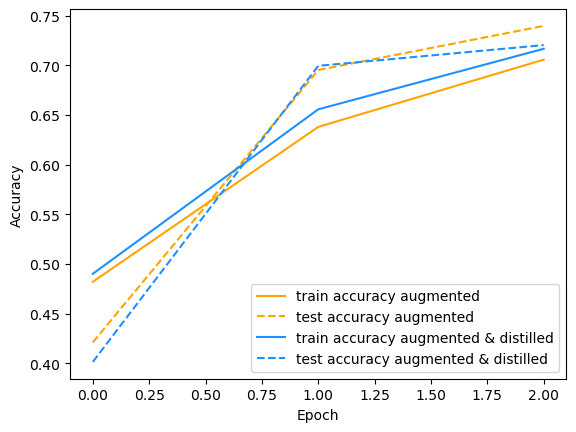

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(wm_10_aug_history['categorical_accuracy'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(wm_10_aug_history['val_categorical_accuracy'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(wm_10_aug_dist_history['categorical_accuracy'],
         label='train accuracy augmented & distilled',
         c='dodgerblue', ls='-')
plt.plot(wm_10_aug_dist_history['val_categorical_accuracy'],
         label='test accuracy augmented & distilled',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Width Multiplier = 1.4

In [ ]:
params = {
    'learning_rate': 5e-3,
    'dropout_rate': 0.15,
    'l2_reg_weight': 1e-4,
    'alpha': 1.0,
    'data_augmentation': True,
}
_, wm_14_aug_dist_history = train_model_with_distillation(
    width_multiplier=1.4, 
    teacher_model_with_logits=teacher_model_with_logits, 
    params=params)

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_16 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_150 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_151 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 16, 16, 32)        0  

INFO:tensorflow:Assets written to: /tmp/tmpwd_p9m1p/assets
2024-05-12 18:19:49.659122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 18:19:49.659256: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 18:19:49.659321: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 18:19:49.659690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 18:19:49.659776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_14_aug_dist_float.tflite, Quantized: False
Model Size: 10186.38 KB
Accuracy: 0.6733
INFO:tensorflow:Assets written to: /tmp/tmpfeorbw6v/assets


INFO:tensorflow:Assets written to: /tmp/tmpfeorbw6v/assets
2024-05-12 18:20:07.051133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 18:20:07.051248: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-12 18:20:07.051315: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-05-12 18:20:07.051616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-12 18:20:07.051769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 30 deviceMemorySize: 5.79Gi

Model Name: wm_14_aug_dist_quantized.tflite, Quantized: True
Model Size: 2572.96 KB
Accuracy: 0.6702
